# ReAct Agent using LangGraph (Reason + Act Workflow)

- This notebook demonstrates how to build a ReAct-style agent using LangGraph.
The agent can reason about a query, decide whether to call tools (ArXiv, Tavily),
execute them, and continue reasoning until it reaches a final answer.


In [31]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")

### Initialize External Tools

- We configure ArXiv and Tavily as external tools that the agent can call
during reasoning steps.


In [32]:
# tools
from langchain_community.tools import TavilySearchResults
from langchain_community.utilities import ArxivAPIWrapper
from langchain_community.tools import ArxivQueryRun

arxiv_wrapper=ArxivAPIWrapper(top_k_results=1,doc_content_chars_max=300)
arxiv=ArxivQueryRun(api_wrapper=arxiv_wrapper)

tavily_search=TavilySearchResults(max_results=2)



### Initialize LLM and Bind Tools

- We use Groq-hosted Qwen model and bind the tools so the model can decide
when to call them during reasoning.


In [33]:
from langchain_groq import ChatGroq

llm=ChatGroq(model="qwen/qwen3-32b")

tools =[arxiv,tavily_search]
llm.invoke("hi")

AIMessage(content='<think>\nOkay, the user just said "hi". I need to respond appropriately. Since it\'s a greeting, I should reply in a friendly and welcoming manner. Maybe ask how they\'re doing or offer assistance. Let me keep it simple and open-ended to encourage them to elaborate on what they need help with. I should also make sure the tone is positive and approachable.\n</think>\n\nHello! How can I assist you today? 😊', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 90, 'prompt_tokens': 9, 'total_tokens': 99, 'completion_time': 0.170290727, 'prompt_time': 0.000395184, 'queue_time': 0.13604462, 'total_time': 0.170685911}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_5cf921caa2', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--3cab351f-2424-4356-8556-952e67bcc182-0', usage_metadata={'input_tokens': 9, 'output_tokens': 90, 'total_tokens': 99})

In [34]:
model=llm.bind_tools(tools)

In [35]:
model.invoke("What is attention all you need")

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking "What is attention all you need." I recognize that "Attention All You Need" is the title of a seminal paper in the field of natural language processing. The paper introduced the Transformer model, which relies entirely on attention mechanisms. Since this is a well-known paper, it\'s likely available on arXiv.org. The user probably wants a summary of the paper\'s main contributions. I should use the arxiv function to search for this paper. The query should be the exact title to ensure the correct result. I\'ll call the arxiv function with the query "Attention All You Need" to retrieve the information.\n', 'tool_calls': [{'id': 's9yzhnzr0', 'function': {'arguments': '{"query":"Attention All You Need"}', 'name': 'arxiv'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 157, 'prompt_tokens': 302, 'total_tokens': 459, 'completion_time': 0.29346622, 'prompt_time': 0.03168580

### Define Graph State

- The graph state stores the conversation messages and allows LangGraph
to automatically append new messages after each step.


In [36]:
from typing import Annotated,TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph.message import add_messages

class GraphState(TypedDict):
    messages:Annotated[list[BaseMessage],add_messages]

### Agent Node

- This node invokes the LLM and lets it decide whether to answer directly
or call a tool based on the user query.


In [37]:
def agent_response(state:GraphState):
    """  
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply use the llm 
    knowledge to answer the user question.

    """
    response = model.invoke(state["messages"]) 
    return {"messages": [response]}

In [38]:
agent_response({"messages":[{"role":"user","content":"what are types of agentic ai?"}]})["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (rp04nzth2)
 Call ID: rp04nzth2
  Args:
    query: types of agentic AI


### Routing Logic

- This function checks whether the LLM produced tool calls.
If yes, the workflow is routed to the tool node.
Otherwise, the execution ends with a final answer.


In [39]:
def route(state: GraphState):
    last = state["messages"][-1]
    if hasattr(last, "tool_calls") and last.tool_calls:
        return "tools"   # send to tool node
    return "agent_response"

### Tool Execution Node

- This node executes the selected tool and returns the result back to the agent.


In [40]:
from langgraph.prebuilt import ToolNode

tool_node = ToolNode([arxiv, tavily_search])

### Build LangGraph Workflow

- We create a loop:
START → Agent → (Tools if needed) → Agent → END


In [41]:
from langgraph.graph import StateGraph,START,END

graph=StateGraph(GraphState)

graph.add_node("agent_response", agent_response)
graph.add_node("tools", tool_node)

graph.add_edge(START, "agent_response")
graph.add_conditional_edges("agent_response", route, 
    {"tools": "tools", "agent_response": END}
)

# After tools run, go back to LLM:
graph.add_edge("tools", "agent_response")

graph_builder = graph.compile()

### Visualize the Agent Workflow Graph


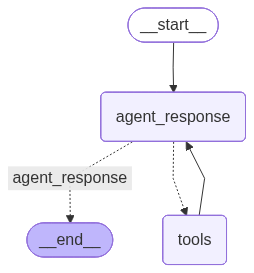

In [42]:
from IPython.display import Image, display
display(Image(graph_builder.get_graph(xray=True).draw_mermaid_png()))

### Test the ReAct Agent


In [49]:

input = {
    "messages": [
        {
            "role": "user",
            "content": "what is machine learning?",
        }
    ]
}
response=graph_builder.invoke(input)
for message in response['messages']:
    message.pretty_print()


================================ Human Message =================================

what is machine learning?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (yfmzb51xx)
 Call ID: yfmzb51xx
  Args:
    query: what is machine learning?
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Machine learning - Wikipedia", "url": "https://en.wikipedia.org/wiki/Machine_learning", "content": "Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks \"Task (computing)\") without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks \"Neural network (machine learning)\"), a class of statistical algorithms, to surpass 

In [50]:
input = {
    "messages": [
        {
            "role": "user",
            "content": "what is attention all you need?",
        }
    ]
}
response=graph_builder.invoke(input)
for message in response['messages']:
    message.pretty_print()

================================ Human Message =================================

what is attention all you need?
================================== Ai Message ==================================
Tool Calls:
  arxiv (3z543n440)
 Call ID: 3z543n440
  Args:
    query: Attention Is All You Need
================================= Tool Message =================================
Name: arxiv

Published: 2021-05-06
Title: Do You Even Need Attention? A Stack of Feed-Forward Layers Does Surprisingly Well on ImageNet
Authors: Luke Melas-Kyriazi
Summary: The strong performance of vision transformers on image classification and other vision tasks is often attributed to the design of their mult
================================== Ai Message ==================================

The paper **"Attention Is All You Need"** (2017) by Vaswani et al. introduced the **Transformer model**, a groundbreaking architecture that relies entirely on **self-attention mechanisms** to process sequential data (like text). It